In [1]:
import tensorflow as tf

In [2]:
!nvidia-smi

Mon Mar 24 23:24:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.70                 Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0              9W /   40W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm

In [6]:
DATADIR = r"C:\Users\New Asus\Documents\FIT4701_2025_Sem1\training_img_dataset\side_dataset\side_micro"

CATEGORIES = ["clap", "punching", "pushpull", "rubhand", "waving"]

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
        # plt.imshow(img_array, cmap='gray')
        # plt.show()

        break
    break 

In [7]:
IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

In [8]:
training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()

print(len(training_data))

100%|██████████| 1210/1210 [00:01<00:00, 1062.31it/s]

6099


In [9]:
import random

random.shuffle(training_data)

In [10]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)  # Convert y to NumPy array
# y = to_categorical(y, num_classes=5)  # Ensure 'num_classes' matches your output layer

In [11]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [12]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [13]:
X = X/255.0
y = to_categorical(y, num_classes=5)

In [14]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [15]:
cnn.compile(  loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
history = cnn.fit(X, y, epochs=10, validation_split=0.25)
split_idx = int(0.75 * len(X))  # 75% training, 25% validation
X_val = X[split_idx:]
y_val = y[split_idx:]

val_loss, val_acc = cnn.evaluate(X_val, y_val)
print(f"Final Validation Accuracy: {val_acc}")

Epoch 1/10
143/143 [==============================] - 13s 17ms/step - loss: 1.4543 - accuracy: 0.3577 - val_loss: 1.2624 - val_accuracy: 0.4702
Epoch 2/10
143/143 [==============================] - 1s 8ms/step - loss: 1.1219 - accuracy: 0.5501 - val_loss: 1.1242 - val_accuracy: 0.5436
Epoch 3/10
143/143 [==============================] - 1s 8ms/step - loss: 0.9700 - accuracy: 0.6207 - val_loss: 1.0027 - val_accuracy: 0.6052
Epoch 4/10
143/143 [==============================] - 1s 8ms/step - loss: 0.7886 - accuracy: 0.6996 - val_loss: 0.9573 - val_accuracy: 0.6216
Epoch 5/10
143/143 [==============================] - 1s 8ms/step - loss: 0.6527 - accuracy: 0.7606 - val_loss: 0.8689 - val_accuracy: 0.6734
Epoch 6/10
143/143 [==============================] - 1s 7ms/step - loss: 0.5294 - accuracy: 0.8139 - val_loss: 0.8577 - val_accuracy: 0.6787
Epoch 7/10
143/143 [==============================] - 1s 8ms/step - loss: 0.4193 - accuracy: 0.8540 - val_loss: 0.8575 - val_accuracy: 0.7075
Epoc

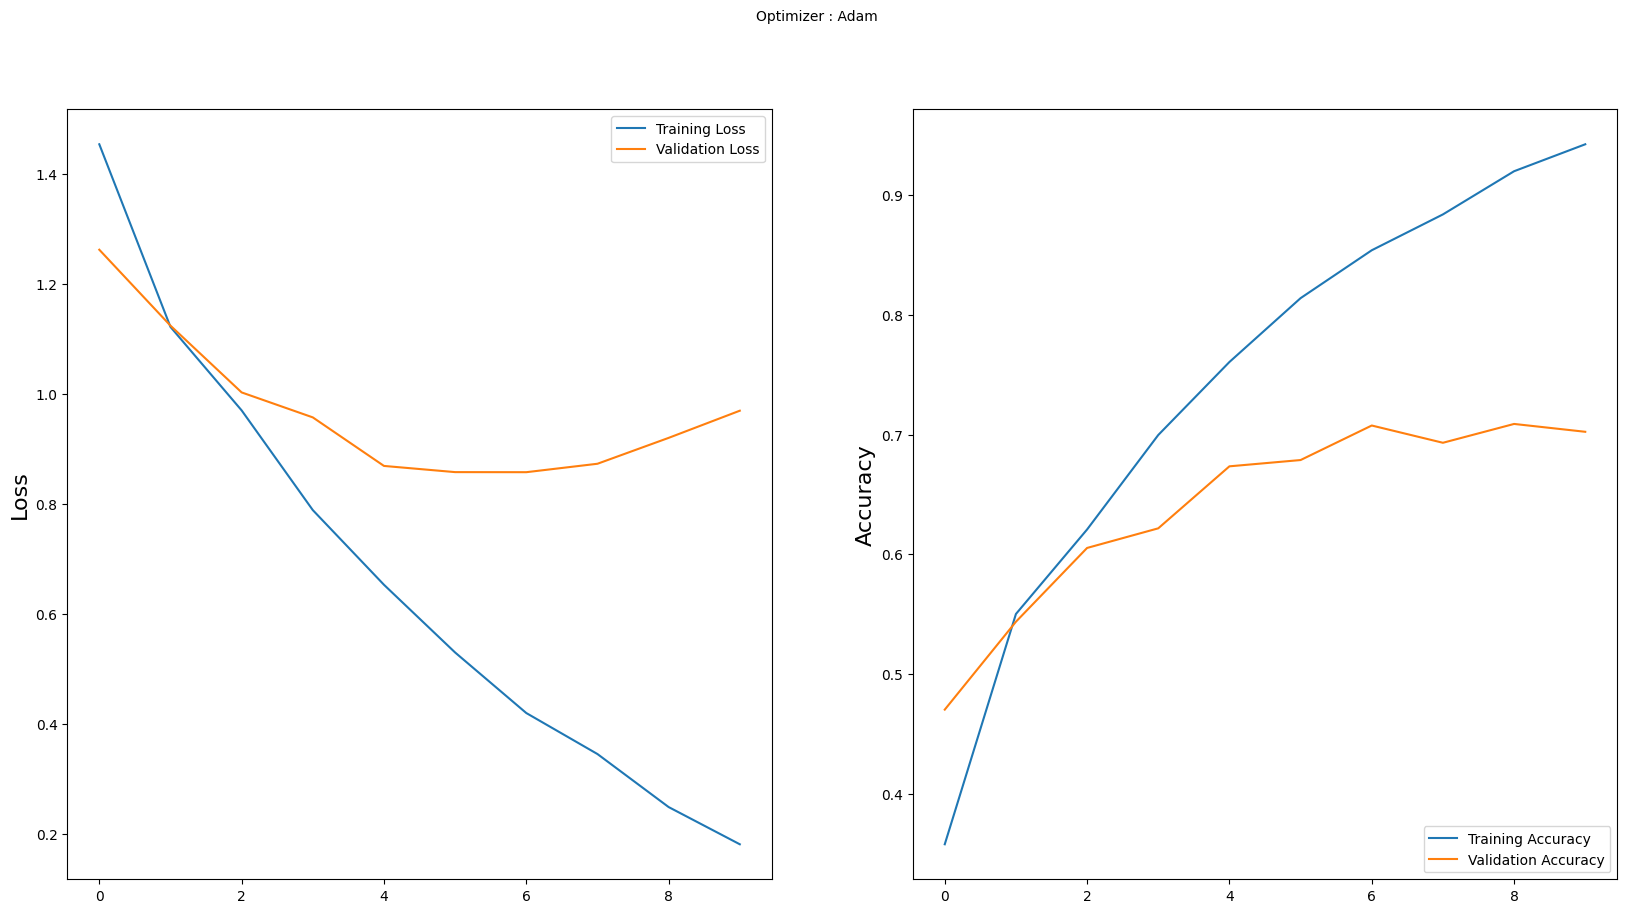

In [17]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()